In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
# from easydict import EasyDict as edict
import drms
from sunpy.instr.goes import flareclass_to_flux, flux_to_flareclass
#flareclass_to_flux_extended = lambda s: -9 * u('W/m^2') if s == '' else flareclass_to_flux(s)
#flux_to_flareclass_extended = lambda q: '-9' if s == '' else flareclass_to_flux(s)

from utils import get_log_intensity

%load_ext autoreload
%autoreload 2

FEATURES = ['AREA', 'USFLUXL', 'MEANGBL', 'R_VALUE', 'FLARE_INDEX']

## GOES flare events

Check a few patterns in goes_class:

In [8]:
goes = pd.read_csv('/data2/GOES/goes.csv')
goes[goes['goes_class'].isna()]

Empty DataFrame
Columns: [event_date, start_time, peak_time, end_time, goes_class, goes_location, noaa_active_region]
Index: []

In [9]:
goes[goes['goes_class'] == '']

Empty DataFrame
Columns: [event_date, start_time, peak_time, end_time, goes_class, goes_location, noaa_active_region]
Index: []

In [13]:
goes[goes['goes_class'] == 'C']

Empty DataFrame
Columns: [event_date, start_time, peak_time, end_time, goes_class, goes_location, noaa_active_region]
Index: []

In [5]:
goes[goes['goes_class'].str.match('X\d\d')] # X10.0+ flares

event_date               start_time                peak_time  \
1957  2001-04-02  2001-04-02T21:32:00.000  2001-04-02T21:51:00.000   
1982  2001-04-15  2001-04-15T13:19:00.000  2001-04-15T13:50:00.000   
4820  2003-10-28  2003-10-28T09:51:00.000  2003-10-28T11:10:00.000   
4826  2003-10-29  2003-10-29T20:37:00.000  2003-10-29T20:49:00.000   
4861  2003-11-04  2003-11-04T19:29:00.000  2003-11-04T19:50:00.000   
8063  2005-09-07  2005-09-07T17:17:00.000  2005-09-07T17:40:00.000   

                     end_time goes_class goes_location  noaa_active_region  
1957  2001-04-02T22:03:00.000       X20.        (0, 0)                9393  
1982  2001-04-15T13:55:00.000       X14.     (85, -20)                9415  
4820  2003-10-28T11:24:00.000       X17.        (0, 0)               10486  
4826  2003-10-29T21:01:00.000       X10.      (2, -15)               10486  
4861  2003-11-04T20:06:00.000       X28.     (83, -19)               10486  
8063  2005-09-07T18:03:00.000       X17.    (-77, -11)               10808

Remove the above singular cases:

In [16]:
goes = goes[goes['goes_class'] != 'C']

Validate there is no singular cases left.

Allowed patterns of `goes['goes_class']`:
* Normal sized flares: `'[A|B|C|M|X][1-9][.][0-9]'` or `[A|B|C|M|X][1-9]`
* Super X-class flares: `'X\d\d.'`

In [19]:
goes[~goes['goes_class'].str.fullmatch('([A|B|C|M|X][1-9]([.][0-9])?|X\d\d.)')]
# There shouldn't be any record that doesn't match the above patterns

Empty DataFrame
Columns: [event_date, start_time, peak_time, end_time, goes_class, goes_location, noaa_active_region]
Index: []

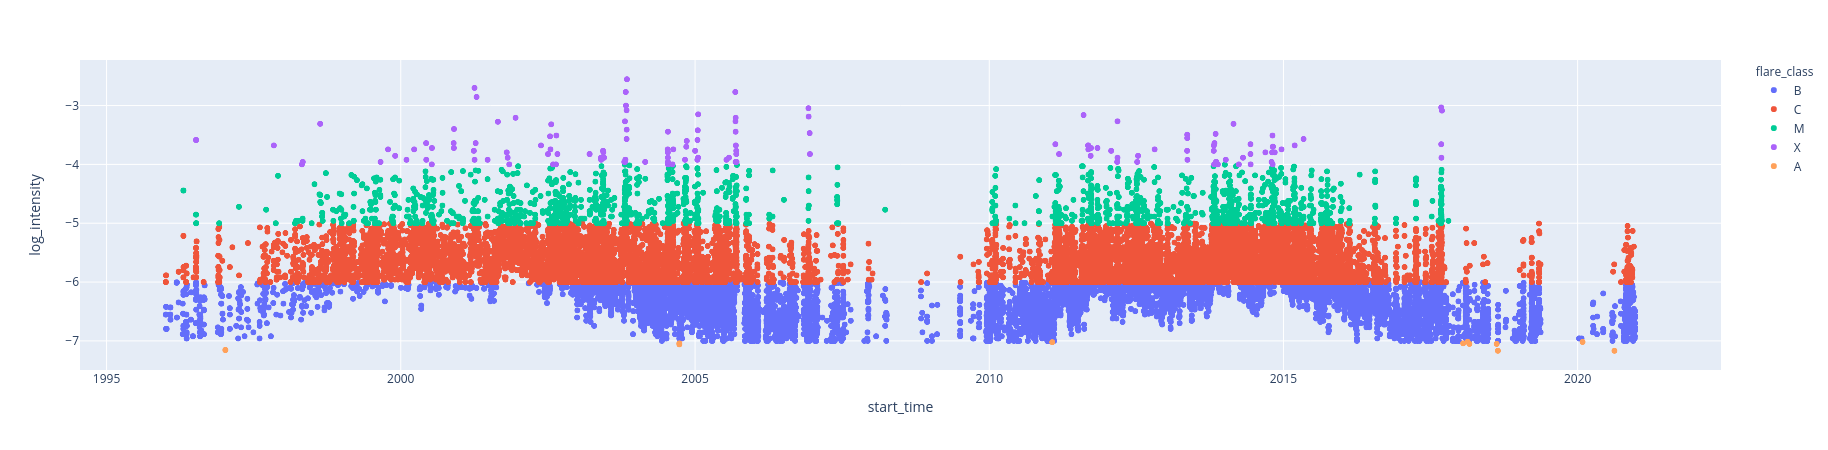

In [20]:
goes_vis = goes.copy()
goes_vis['log_intensity'] = goes_vis['goes_class'].apply(get_log_intensity)
goes_vis['flare_class'] = goes_vis['goes_class'].apply(lambda s: 'Unknown' if s == '' else s[0])
goes_vis['start_time'] = goes_vis['start_time'].apply(drms.to_datetime)
px.scatter(goes_vis, x='start_time', y='log_intensity', color='flare_class', hover_data=['noaa_active_region'])

In [26]:
# mdi.smarp_cea_96m:
# First Record = mdi.smarp_cea_96m[1][1996.04.23_00:00:00_TAI]
# Last Record = mdi.smarp_cea_96m[13670][2010.10.27_22:24:00_TAI]
smarp_start = drms.to_datetime('1996-04-23 00:00:00').strftime('%Y-%m-%dT%H:%M:%S:00.000') #2001-04-02T21:32:00.000
smarp_end = drms.to_datetime('2010-10-28 00:00:00').strftime('%Y-%m-%dT%H:%M:%S:00.000')
sharp_end = drms.to_datetime('2020-12-02 00:00:00').strftime('%Y-%m-%dT%H:%M:%S:00.000') # 1d later than the obervations
goes.loc[(goes['start_time'] >= smarp_start) &
         (goes['start_time'] < smarp_end), 'dataset'] = 'smarp'
goes.loc[(goes['start_time'] >= smarp_end) &
         (goes['start_time'] <= sharp_end), 'dataset'] = 'sharp'

stats = (goes
         .assign(flare_class=goes['goes_class'].str[0])
         .groupby('dataset')
         ['flare_class']
         .value_counts()
         .unstack(fill_value=0))
stats['>=M1.0'] = stats['M'] + stats['X']
stats['<M1.0'] = stats['A'] + stats['B'] + stats['C']
stats['strong flare rate'] = stats['>=M1.0'] / (stats['>=M1.0'] + stats['<M1.0'])
stats

flare_class  A     B     C    M   X  >=M1.0  <M1.0  strong flare rate
dataset                                                              
sharp        8  4495  6889  705  50     755  11392           0.062155
smarp        4  4052  5267  785  91     876   9323           0.085891

## Label distribution

In [41]:
df = edict()
df.sharp = pd.read_csv('../datasets/preprocessed/M_Q_24hr/sharp.csv')
df.smarp = pd.read_csv('../datasets/preprocessed/M_Q_24hr/smarp.csv')

/home/zeyusun/.conda/envs/arnet/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.



In [42]:
df.sharp

prefix  arpnum              t_start                t_end  label flares  \
0       HARP     241  2010-10-31 14:24:00  2010-11-01 14:24:00  False    NaN   
1       HARP     241  2010-10-31 16:00:00  2010-11-01 16:00:00  False    NaN   
2       HARP     241  2010-10-31 17:36:00  2010-11-01 17:36:00  False    NaN   
3       HARP     241  2010-10-31 19:12:00  2010-11-01 19:12:00  False    NaN   
4       HARP     241  2010-10-31 20:48:00  2010-11-01 20:48:00  False    NaN   
...      ...     ...                  ...                  ...    ...    ...   
69193   HARP    7487  2020-11-29 17:36:00  2020-11-30 17:36:00  False    NaN   
69194   HARP    7487  2020-11-29 19:12:00  2020-11-30 19:12:00  False    NaN   
69195   HARP    7487  2020-11-29 20:48:00  2020-11-30 20:48:00  False    NaN   
69196   HARP    7487  2020-11-29 22:24:00  2020-11-30 22:24:00  False    NaN   
69197   HARP    7487  2020-11-30 00:00:00  2020-12-01 00:00:00  False    NaN   

      bad_img_idx  FLARE_INDEX         AREA       USFLUXL  MEANGBL  R_VALUE  
0              []          0.0  3530.093506  6.806878e+21   15.895    3.603  
1              []          0.0  3519.913086  6.669450e+21   16.058    3.614  
2              []          0.0  3510.337891  6.686481e+21   16.365    3.600  
3              []          0.0  3508.229492  6.668666e+21   16.365    3.646  
4              []          0.0  3501.863525  6.623080e+21   16.539    3.348  
...           ...          ...          ...           ...      ...      ...  
69193          []          0.0  1784.708496  2.584030e+21   19.041    0.000  
69194          []          0.0  1890.129028  2.806127e+21   19.280    0.000  
69195          []          0.0  2077.711426  3.027317e+21   18.982    0.000  
69196          []          0.0  2230.751709  3.124522e+21   18.521    0.000  
69197          []          0.0  2268.437744  3.127745e+21   18.454    0.000  

[69198 rows x 12 columns]

In [47]:
stats = {}
for dataset in ['smarp', 'sharp']:
    labels = df[dataset]['label']
    stats[dataset] = {
        'event': labels.sum(),
        'non-event': (~labels).sum(),
        'event rate': labels.sum() / len(labels)
    }
pd.DataFrame.from_dict(stats, orient='index')

event  non-event  event rate
smarp   4601     130695    0.034007
sharp   2849      66349    0.041172

In [50]:
#px.scatter(df.sharp, x='t_end', y='R_VALUE', color='label', hover_data=['prefix', 'arpnum'])

In [12]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

PREFIX = 'HARP'
keywords = ['USFLUX', 'MEANGBZ', 'R_VALUE', 'AREA', 'FLARE_INDEX']

fig = make_subplots(rows=len(keywords), cols=2,
                    shared_xaxes='all',
                    shared_yaxes='rows',
                    column_titles=['Training set', 'Testing set'],
                    row_titles=keywords,
                    vertical_spacing=0.02)
colors = lambda labels: [px.colors.qualitative.Plotly[i] for i in labels.astype(int)]

def add_keyword(fig, keyword, row):
    fig.add_trace(go.Scattergl(x=df.sharp.train.t_end, y=df.sharp.train[keyword],
                               customdata=df.sharp.train['arpnum'].to_numpy(),
                               hovertemplate=("<b>%{y} </b><br><br>" +
                                              "time: %{x}<br>" +
                                              f"{PREFIX} " + "%{customdata}<br>"),
                               mode='markers',
                               marker=dict(color=colors(df.sharp.train.label),
                                           opacity=0.5)),
                  row=row, col=1)

    fig.add_trace(go.Scattergl(x=df.sharp.test.t_end, y=df.sharp.test[keyword],
                               customdata=df.sharp.test['arpnum'].to_numpy(),
                               hovertemplate=("<b>%{y} </b><br><br>" +
                                              "time: %{x}<br>" +
                                              f"{PREFIX} " + "%{customdata}<br>"),
                               mode='markers',
                               marker=dict(color=colors(df.sharp.test.label),
                                           opacity=0.5)),
                  row=row, col=2)
    return fig

for i, keyword in enumerate(keywords):
    fig = add_keyword(fig, keyword, i+1)

fig.update_layout(#height=1000,# width=600, # extend to the entire webpage
                  title_text=f"{PREFIX} Keywords")
fig.write_html('outputs/eda_sharp_time_series.html')
#fig.show()

In [13]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

PREFIX = 'TARP'
keywords = ['USFLUX', 'MEANGBZ', 'R_VALUE', 'AREA', 'FLARE_INDEX']

fig = make_subplots(rows=len(keywords), cols=2,
                    shared_xaxes='all',
                    shared_yaxes='rows',
                    column_titles=['Training set', 'Testing set'],
                    row_titles=keywords,
                    vertical_spacing=0.02)
colors = lambda labels: [px.colors.qualitative.Plotly[i] for i in labels.astype(int)]

def add_keyword(fig, keyword, row):
    fig.add_trace(go.Scattergl(x=df.smarp.train.t_end, y=df.smarp.train[keyword],
                               customdata=df.smarp.train['arpnum'].to_numpy(),
                               hovertemplate=("<b>%{y} </b><br><br>" +
                                              "time: %{x}<br>" +
                                              f"{PREFIX} " + "%{customdata}<br>"),
                               mode='markers',
                               marker=dict(color=colors(df.smarp.train.label),
                                           opacity=0.5)),
                  row=row, col=1)

    fig.add_trace(go.Scattergl(x=df.smarp.test.t_end, y=df.smarp.test[keyword],
                               customdata=df.smarp.test['arpnum'].to_numpy(),
                               hovertemplate=("<b>%{y} </b><br><br>" +
                                              "time: %{x}<br>" +
                                              f"{PREFIX} " + "%{customdata}<br>"),
                               mode='markers',
                               marker=dict(color=colors(df.smarp.test.label),
                                           opacity=0.5)),
                  row=row, col=2)
    return fig

for i, keyword in enumerate(keywords):
    fig = add_keyword(fig, keyword, i+1)

fig.update_layout(#height=1000,# width=600,
                  title_text=f"{PREFIX} Keywords")
fig.write_html('outputs/eda_smarp_time_series.html')
#fig.show()

In [14]:
def analyze_data_df(df):
    fig = px.scatter_matrix(df,
                            height=800,
                            dimensions=FEATURES,
                            color='label')
    fig.show()

    df.hist(bins=20)
    plt.tight_layout()
    plt.show()

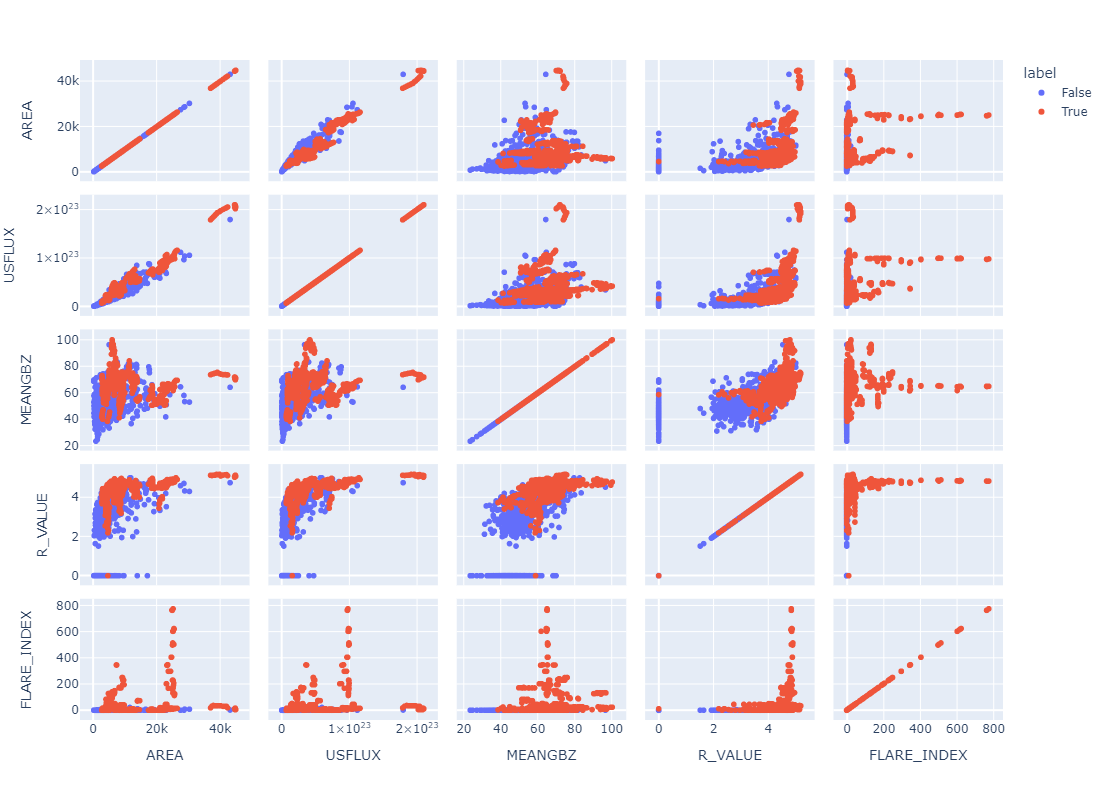

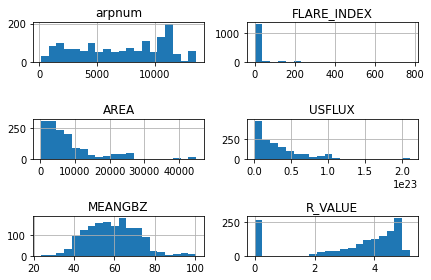

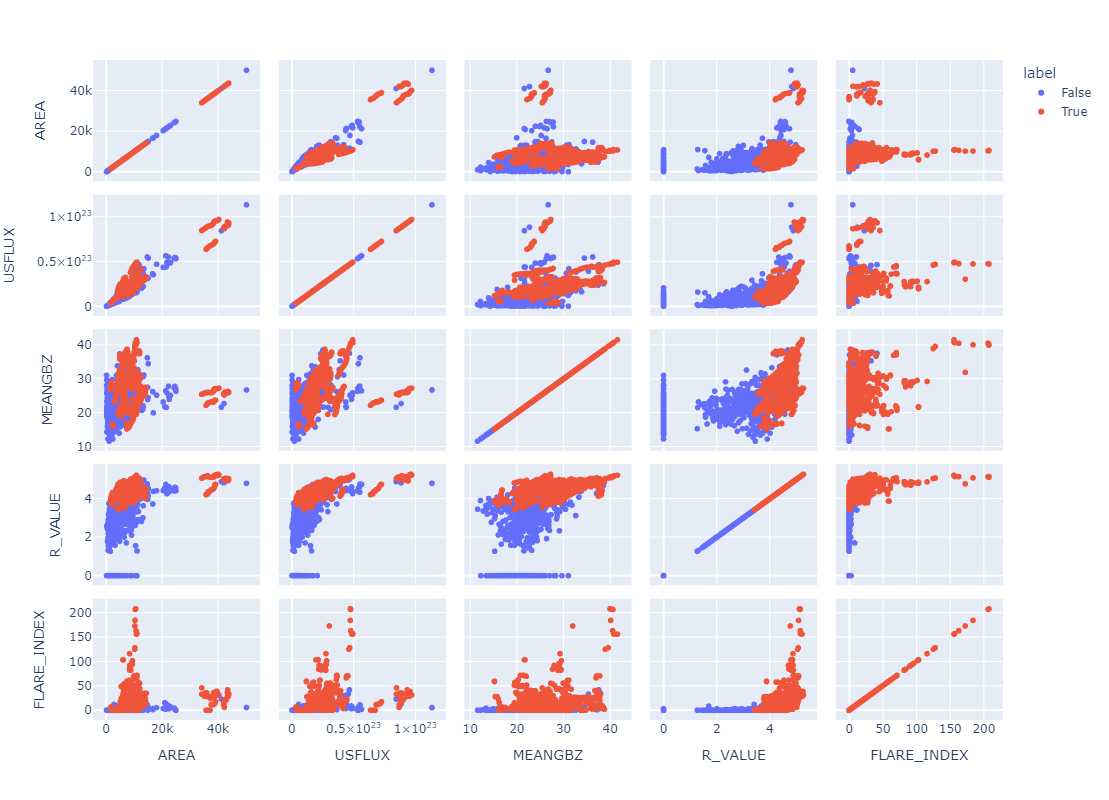

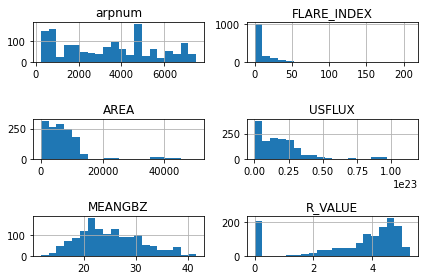

In [15]:
df_smarp_test = pd.read_csv('datasets/smarp/test.csv')
df_sharp_test = pd.read_csv('datasets/sharp/test.csv')
analyze_data_df(df_smarp_test)
analyze_data_df(df_sharp_test)

## Prepare pairplots for paper

In [23]:
import sys
sys.path.append("../")


In [34]:
import seaborn as sns
from utils import draw_pairplot

In [6]:
df_smarp = pd.read_csv('../datasets/M_Q_24hr/smarp.csv')
df_sharp = pd.read_csv('../datasets/M_Q_24hr/sharp.csv')

/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
columns = ['USFLUXL', 'MEANGBL', 'R_VALUE', 'AREA']

## SHARP

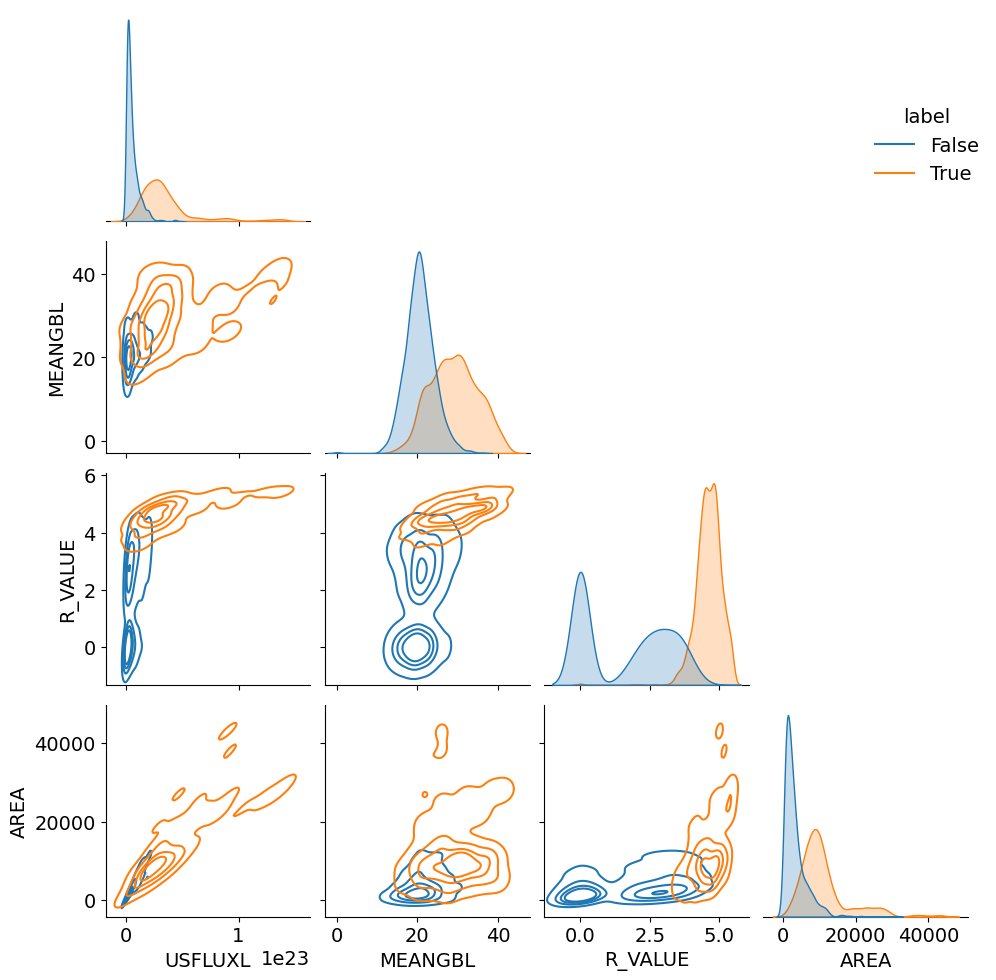

In [107]:
labels = [False, True]
Xs = [df_sharp.loc[df_sharp['label'] == i, columns].values
      for i in labels]

pg1 = draw_pairplot(Xs, labels, columns)
sns.move_legend(pg1, "upper right", bbox_to_anchor=(0.9, 0.9), framealpha=0.8)

In [95]:
pg1.figure.axes

[<AxesSubplot:>,
 <AxesSubplot:xlabel='USFLUXL', ylabel='MEANGBL'>,
 <AxesSubplot:>,
 <AxesSubplot:xlabel='USFLUXL', ylabel='R_VALUE'>,
 <AxesSubplot:xlabel='MEANGBL', ylabel='R_VALUE'>,
 <AxesSubplot:>,
 <AxesSubplot:xlabel='USFLUXL', ylabel='AREA'>,
 <AxesSubplot:xlabel='MEANGBL', ylabel='AREA'>,
 <AxesSubplot:xlabel='R_VALUE', ylabel='AREA'>,
 <AxesSubplot:xlabel='AREA'>,
 <AxesSubplot:xlabel='USFLUXL', ylabel='Density'>,
 <AxesSubplot:xlabel='MEANGBL', ylabel='Density'>,
 <AxesSubplot:xlabel='R_VALUE', ylabel='Density'>,
 <AxesSubplot:xlabel='AREA', ylabel='Density'>]

In [96]:
for i, ax in enumerate(pg1.figure.axes[-8:-4]):
    print(ax.get_xlim())
    #ax.set_xlim(xlims[i])

(-1.6979108347207297e+22, 1.623634143472073e+23)
(-2.978672247525691, 47.85183687140247)
(-1.3354108620326612, 6.237410862032661)
(-5424.842228132515, 51018.05682713252)


In [119]:
# plt.tight_layout() # useless
pg1.figure.savefig('pairplot_sharp.pdf')
pg1.figure.savefig('pairplot_sharp.png')

## SMARP

In [109]:
labels = [False, True]
Xs = [df_smarp.loc[df_smarp['label'] == i, columns].values
      for i in labels]

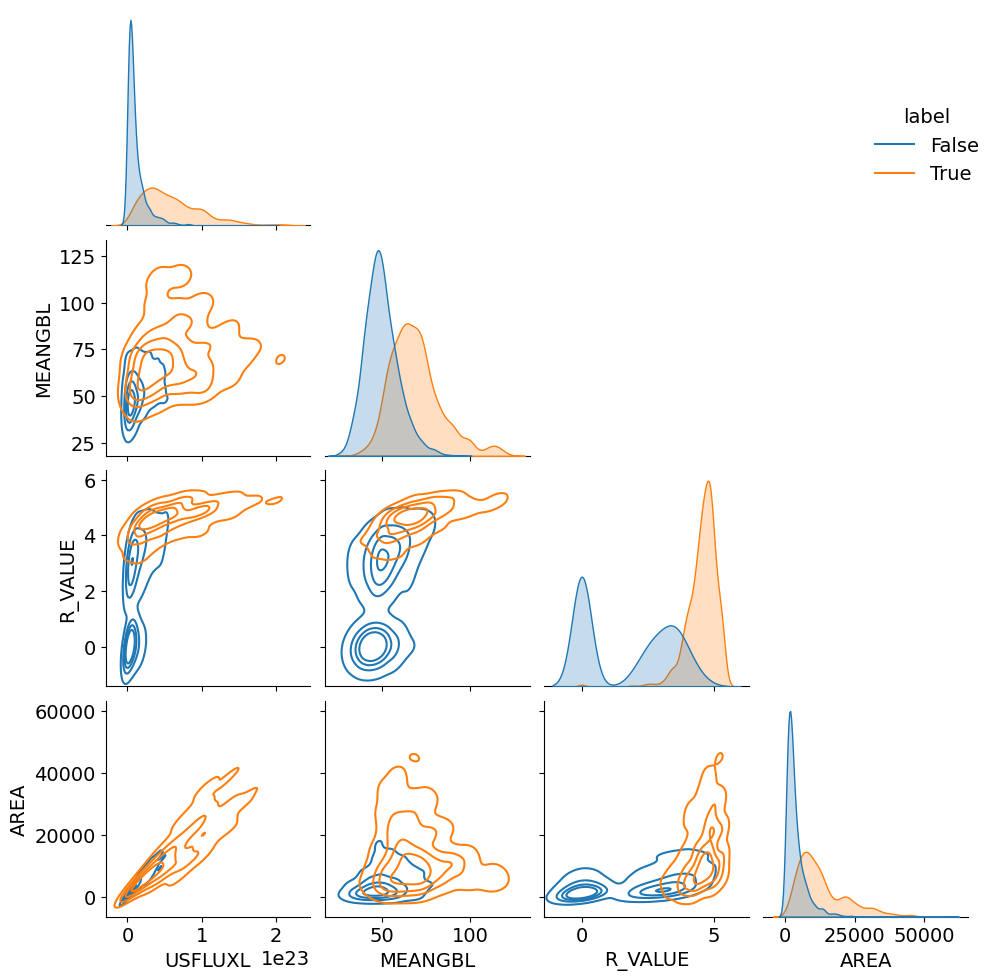

In [110]:
pg2 = draw_pairplot(Xs, labels, columns)
sns.move_legend(pg2, "upper right", bbox_to_anchor=(0.9, 0.9), framealpha=0.8)

In [115]:
for ax1, ax2 in zip(pg1.figure.axes, pg2.figure.axes):
    if ax1.get_xlabel() + ax2.get_xlabel() != '':
        xlim1 = ax1.get_xlim()
        xlim2 = ax2.get_xlim()
        xlim3 = [min(xlim1[0], xlim2[0]),
                 max(xlim1[1], xlim2[1])]
        #print(ax1.get_xlabel(), ax2.get_xlabel())
        #print(xlim1, xlim2)
        ax1.set_xlim(xlim3)
        ax2.set_xlim(xlim3)
    
    if ax1.get_ylabel() + ax2.get_ylabel() != '':
        ylim1 = ax1.get_ylim()
        ylim2 = ax2.get_ylim()
        ylim3 = [min(ylim1[0], ylim2[0]),
                 max(ylim1[1], ylim2[1])]
        #print(ax1.get_ylabel(), ax2.get_ylabel())
        #print(ylim1, ylim2)
        ax1.set_ylim(ylim3)
        ax2.set_ylim(ylim3)

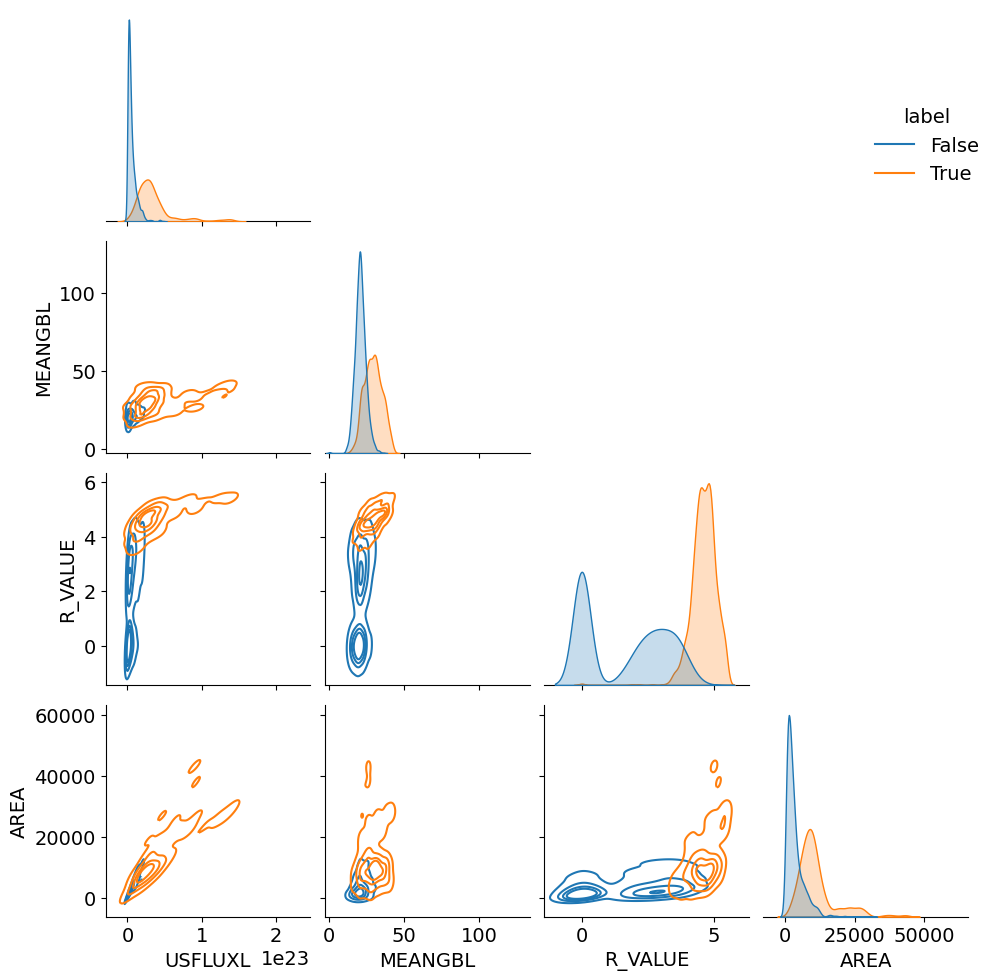

In [116]:
pg1.figure

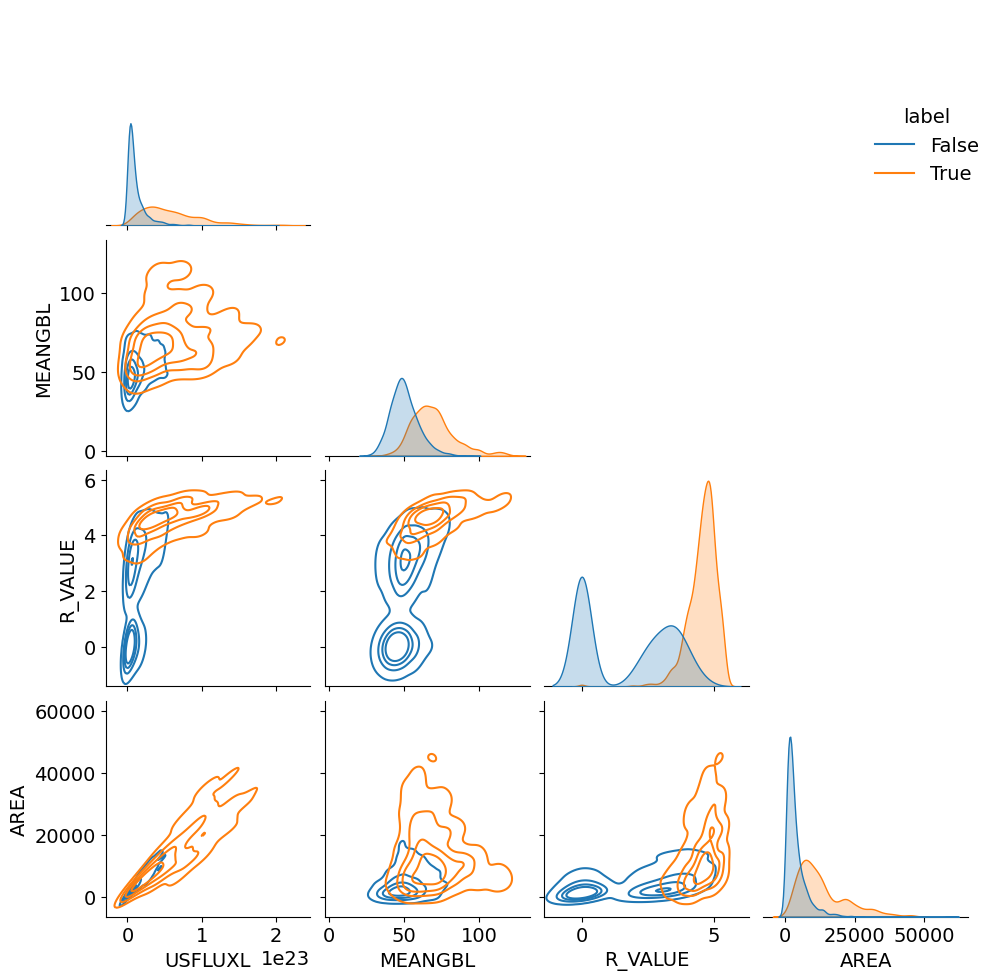

In [117]:
pg2.figure

In [118]:
pg2.figure.savefig('pairplot_smarp.pdf')
pg2.figure.savefig('pairplot_smarp.png')